University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  
Based on notebook by Antti Honkela  

# Lecture 6: Markov chain Monte Carlo (MCMC) basics

Background reading: please see Chapter 6 of the "Course notes" available in Moodle.


In [1]:
# imports
import numpy as np
rng = np.random.default_rng(42)

from typing import Callable
from scipy import stats
import seaborn as sns

## 1. Metropolis-Hastings sampling of a 1D target

1. Write a Metropolis-Hastings sampler to draw samples having as target density the standard normal distribution (zero mean, unit variance) $\mathcal{N}(0, 1)$, using the following proposal distribution: $$Q(\theta^\prime ; \theta) = \mathrm{Uniform}(\theta^\prime; \theta-0.5, \theta+0.5).$$ Draw 1000 samples and compute the acceptance rate of your sampler.
2. Throw away the first half of the samples (warmup), from now on we only consider the second half. Plot a normalized (`density=True`) histogram of the samples you have drawn together with the true density. *Hint*: For a 1D array `a`, you can throw away the first half with `a = a[len(a)//2:]`.
3. Plot a trace plot of the samples: a line plot of the samples (*Hint*: Simply use `plt.plot`). Do consecutive samples appear independent or are they correlated? Plot a similar trace of the samples when they are permuted to a random order. Do the curves look simiar?
4. Try increasing the number of samples to 10000 and only including every 10th sample in the plots. This is called *thinning*. (*Hint*: you can extract every 10th element of a numpy.array `theta` using `theta[::10]`.)
5. Try changing the bounds of the proposal distribution such that they remain symmetric about $\theta$, run the sampler and redraw the plots. Can you make the samples appear more independent? Is there a connection between the acceptance rate and the appearance of the plots?
6. Compute the expectation $E[\theta^2]$ using your samples using the Monte Carlo approximation
$$ E[f(\theta)] \approx \frac{1}{n} \sum_{i=1}^n f(\theta_i) \quad \Longrightarrow \quad E[\theta^2] \approx \frac{1}{n} \sum_{i=1}^n (\theta_i)^2, $$
where $\theta_i, i = 1, \dots, n$ are the samples you have drawn. Compare the value you obtained with the known ground truth (i.e., the second moment of a standard normal distribution).

5000


/home/sjack/.cache/pypoetry/virtualenvs/bayesian-analysis-with-python-2PZ-H5WS-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/virtualenvs/bayesian-analysis-with-python-2PZ-H5WS-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sjack/.cache/pypoetry/virtualenvs/bayesian-analysis-with-python-2PZ-H5WS-py3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


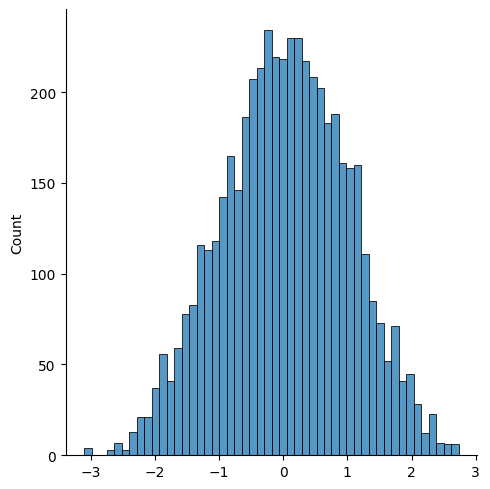

In [10]:
# 1
def metropolis_hastings(theta0: float, n: int, target: Callable[[float], float], proposal_draw: Callable[[float], float]) -> np.ndarray:
    theta = theta0
    thetas = np.zeros(n)
    accepts = 0
    for i in range(n):
        theta_prop = proposal_draw(theta)
        u = rng.uniform(0, 1)
        if np.log(u) < np.log(target(theta_prop)) - np.log(target(theta)):
            theta = theta_prop
            accepts += 1
        thetas[i] = theta
    return thetas, accepts/n

n = 10000


target_pdf = stats.norm(loc=0, scale=1).pdf

samples, _ = metropolis_hastings(
    theta0 = 0,
    n = n,
    target = target_pdf,
    proposal_draw = lambda theta: rng.uniform(theta -.5, theta + .5)
)

samples = samples[n//2:]
print(len(samples))
sns.displot(samples, bins=50)

## 2. Tuning a Metropolis-Hastings sampler

Let us consider Metropolis-Hastings sampling of a $\mathcal{N}(0, 1)$ target with $$q(\theta', \theta) = \mathcal{N}(\theta';\; \theta, \sigma^2)$$ as the proposal. Your aim is to tune the proposal width $\sigma > 0$ to obtain optimal mixing.

1. Implement the sampler and run it 20 times with a number of different values of $\sigma$. Record the acceptance rates and the mean and variance of the samples you obtain. What value of $\sigma$ gives the most accurate estimates? What is the corresponding acceptance rate?
2. Repeat the task with $q(\theta', \theta) = \mathrm{Uniform}(\theta-\sigma/2, \theta+\sigma/2)$ as the proposal.  What value of $\sigma$ now gives the most accurate estimates? What is the corresponding acceptance rate?

In [11]:
sigmas = np.linspace(1e-5, 2, 50)

n = 10000
acceptance_rates = np.zeros(len(sigmas))
for s in sigmas:

    samples, acceptance_rate = metropolis_hastings(
        theta0 = 0,
        n = 2000,
        target = stats.norm(loc=0, scale=1).pdf,
        proposal_draw = lambda x: stats.norm(loc=x, scale=s).rvs()
    )
    print(f"sigma = {s}, acceptance rate = {acceptance_rate}")

print(f"Optimal sigma = {sigmas[np.argmax(acceptance_rates)]}")

sigma = 1e-05, acceptance rate = 1.0
sigma = 0.040826122448979596, acceptance rate = 0.9835
sigma = 0.08164224489795918, acceptance rate = 0.977
sigma = 0.12245836734693878, acceptance rate = 0.9665
sigma = 0.16327448979591838, acceptance rate = 0.9605
sigma = 0.20409061224489797, acceptance rate = 0.923
sigma = 0.24490673469387758, acceptance rate = 0.928
sigma = 0.28572285714285717, acceptance rate = 0.8885
sigma = 0.32653897959183675, acceptance rate = 0.8955
sigma = 0.36735510204081634, acceptance rate = 0.8845
sigma = 0.4081712244897959, acceptance rate = 0.88
sigma = 0.4489873469387755, acceptance rate = 0.8675
sigma = 0.48980346938775515, acceptance rate = 0.8375
sigma = 0.5306195918367347, acceptance rate = 0.8315
sigma = 0.5714357142857143, acceptance rate = 0.8305
sigma = 0.6122518367346939, acceptance rate = 0.8065
sigma = 0.6530679591836734, acceptance rate = 0.7945
sigma = 0.693884081632653, acceptance rate = 0.7655
sigma = 0.7347002040816326, acceptance rate = 0.768
sigma

## 3. Metropolis-Hastings sampling of a higher dimensional target

1. Implement a Metropolis-Hastings sampler for multivariate targets and test it for sampling from the standard zero-mean, unit covariance $d$-dimensional multivariate normal $\mathcal{N}(0, I_d)$ for $d = 2$ using $Q(\theta' ; \theta) = \mathcal{N}(\theta' ;\; \theta, w I_d)$ as the proposal with $w = 0.5$. Draw 10000 samples and thin by a factor of 10.
2. Plot trace plots, histograms and pairwise scatter plots of all pairs of variables.
3. Run the sampler and draw the plots again with different $w$. How do the results change? Can you see the link between the acceptance ratio and the appearence of the plots?
4. Repeat the analysis for $d=5$.

## 4. Sampling a multimodal distribution, convergence checking

In this exercise we consider Metropolis-Hastings sampling from a two-dimensional unnormalised target distribution
$$ P^*(\theta; R) = \sum_{i=1}^5 \exp\left( -\frac{1}{2} (\theta-\mu_i)^T (\theta - \mu_i) \right) $$
with $\mu_1 = (0, 0), \mu_2 = (R, R), \mu_3 = (R, -R), \mu_4 = (-R, R), \mu_5 = (-R, -R)$. Here $R$ denotes a parameter that specifies the spread of the modes of the distribution.

1. Plot a contour plot of $\log P^*(\theta; R)$ for $R = 6$. *Hint*: We already provide the code for making a contour plot, you only need to write the code for the target log density.
2. Write a Metropolis-Hastings sampler for the target using $q(\theta' ; \theta) = \mathcal{N}(\theta'; \; \theta, I_2)$ as the proposal and run it to obtain 10000 samples.
3. Plot a scatter plot of the samples and compare it to the contour plot. Is the sampler exploring the density well?
4. Start several chains from different initial values and compare the results. Do the chains converge?
5. Try repeating the experiment with $R=3$.
6. Try repeating the experiment with $R=100$ using the same initial points as with $R=3$.
7. Try to get the sampler to explore the density for $R=6$. Try running the sampler for longer, changing the proposal, ...

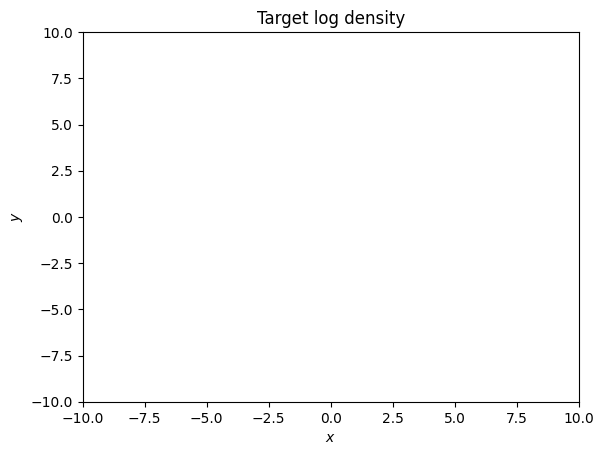

In [4]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.special as scs

npr.seed(41)

def target(theta, R):
    """Target log density."""
    # Write here the code that computes the target log density at theta (a numpy array), for parameter R.    
    return 0.0

# 1
R = 6.0
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for i, x_ in enumerate(x):
    for j, y_ in enumerate(y):
        Z[i,j] = target(np.array([x_, y_]), R)
        
plt.contour(X, Y, Z)
plt.title('Target log density')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()